<a href="https://colab.research.google.com/github/AYA0HASSAN/RAVIR-Segmentation/blob/main/RAVIRSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = 5>Libraries</font><br>
<font size = 2 color = 'gray'>just run that cell</font>

In [1]:
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu111/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html


In [2]:
!pip install -U albumentations

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import torch
from torch import nn
import os
import cv2
import pandas as pd
from os import path
import torchvision
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from typing import Sequence
from torch.utils.data import Dataset
import albumentations as A
import torch.nn.init as I
import gc
import albumentations as A

import numbers
import random
import numpy as np
import torch.optim as optim
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm

In [5]:
torch.version.cuda

'12.1'

In [6]:
torch.cuda.get_device_name()

'Tesla T4'

In [7]:
torch.backends.cudnn.enabled = True

In [8]:
def get_train_augs():
    return A.Compose([
        # A.Resize(512, 512),
        # A.RandomCrop(height=128, width=128),
        A.HorizontalFlip(p=0.05),
        A.VerticalFlip(p=0.05),
        A.Rotate(limit=30, p=0.5),  # Random rotation up to 30 degrees
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.2),
        A.Blur(blur_limit=(3, 7), p=0.2),  # Random blur
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.HorizontalFlip(p=0.05)
    ], p=1.0)

def get_valid_augs():
    return A.Compose([
        # A.Resize(512, 512),
    ], p=1.0)


In [9]:
class SegmentationDataset(Dataset):
    def __init__(self, root, train, augmentations=None, augmentation_times=3):
        self.root = root
        self.train = train
        self.augmentations = augmentations
        self.augmentation_times = augmentation_times if train else 1

        self.images = list(sorted(os.listdir(os.path.join(root, "training_images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "training_masks"))))

        # Split data into train and test sets
        self.images_train, self.images_test, self.masks_train, self.masks_test = train_test_split(
            self.images, self.masks, test_size=0.2, random_state=42)

    def __len__(self):
        if self.train:
            return len(self.images_train) * self.augmentation_times
        else:
            return len(self.images_test)

    def __getitem__(self, idx):
        # Adjust index for augmented samples
        original_idx = idx // self.augmentation_times

        if self.train:
            imagePath = os.path.join(self.root, "training_images/", self.images_train[original_idx])
            maskPath = os.path.join(self.root, "training_masks", self.masks_train[original_idx])
        else:
            imagePath = os.path.join(self.root, "training_images", self.images_test[original_idx])
            maskPath = os.path.join(self.root, "training_masks", self.masks_test[original_idx])

        # Load image and mask
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(maskPath, cv2.IMREAD_GRAYSCALE)

        # Create masks
        veins_mask = (mask == 256).astype(np.float32)
        arteries_mask = (mask == 128).astype(np.float32)
        background_mask = (mask == 0).astype(np.float32)
        mask_onehot = np.stack([background_mask,veins_mask, arteries_mask], axis=-1)

        # Apply augmentations
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask_onehot)
            image = augmented['image']
            mask_onehot = augmented['mask']

        # Transform to tensor and normalize
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask_onehot = np.transpose(mask_onehot, (2, 0, 1)).astype(np.float32)
        image = torch.Tensor(image) / 255.0
        mask_onehot = torch.Tensor(mask_onehot)

        return image, mask_onehot

In [10]:
BATCH_SIZE = 2
root = "/content/gdrive/MyDrive/Deep Learning Labs/RAVIR Dataset/RAVIR Dataset/train"

In [11]:
trainDataset = SegmentationDataset(root,train = True,augmentations = get_train_augs())
testDataset = SegmentationDataset(root,train = False,augmentations = get_valid_augs())

In [12]:
len(testDataset)

5

In [13]:
trainDataLoader = DataLoader(trainDataset , batch_size =BATCH_SIZE , shuffle =True )
testDataLoader = DataLoader(testDataset , batch_size =BATCH_SIZE  )

In [14]:

# Function to convert torch tensor to numpy array and denormalize
def tensor_to_numpy(tensor):
    return tensor.cpu().detach().numpy()

# Function to plot images, masks, and predictions
def plot(images, masks):
    num_samples = len(images)

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(tensor_to_numpy(images[i]).transpose(1, 2, 0), cmap='gray')
        plt.title('Image')

        plt.subplot(1, 3, 2)
        plt.imshow(tensor_to_numpy(masks[i]).transpose(1, 2, 0), cmap='gray')
        plt.title('Ground Truth Mask')

        plt.show()


  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([2, 3, 768, 768])
torch.Size([2, 3, 768, 768])


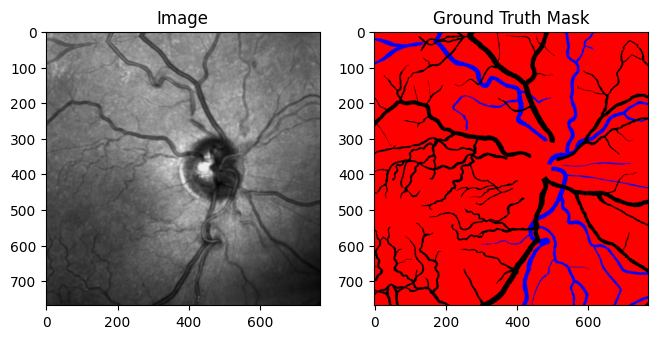

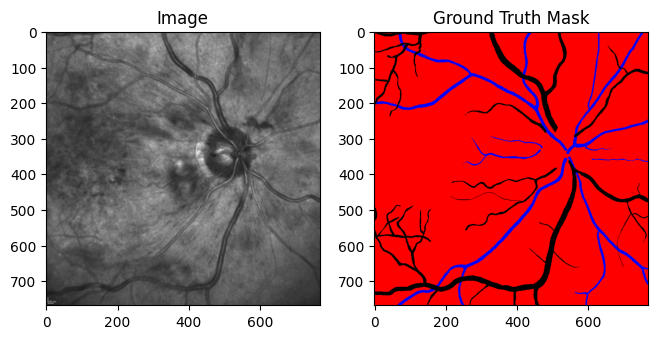

  0%|          | 0/27 [00:03<?, ?it/s]


In [15]:
for image,mask in tqdm(trainDataLoader):
  print(image.shape)
  print(mask.shape)
  plot(image,mask)

  break

In [16]:
len(trainDataLoader)

27

### Losses

In [17]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.0

        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


In [18]:
class IoULoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, predicted, target):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target) - intersection

        iou = (intersection + self.smooth) / (union + self.smooth)

        loss = 1.0 - iou

        return loss

In [19]:
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, y_pred, y_true):
        mask = (y_true != 0).float()
        absolute_percentage_error = torch.abs((y_true - y_pred) / (y_true + 1e-8))

        # Apply the mask to exclude cases where the true value is zero
        masked_absolute_percentage_error = absolute_percentage_error * mask

        # Calculate the mean over non-zero values
        mape = torch.sum(masked_absolute_percentage_error) / torch.sum(mask)

        return mape

In [20]:
class MeanIoU:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    def update(self, y_true, y_pred):
        # Convert to integer type
        y_true = y_true.astype(np.int64)
        y_pred = y_pred.astype(np.int64)

        # Flatten the 2D arrays to 1D
        y_true = y_true.flatten()
        y_pred = y_pred.flatten()

        # Update the confusion matrix
        self.confusion_matrix += np.bincount(self.num_classes * y_true + y_pred,
                                             minlength=self.num_classes**2).reshape(self.num_classes, self.num_classes)

    def reset(self):
        # Reset the confusion matrix
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes), dtype=np.int64)

    def calculate(self):
        # Calculate IoU for each class
        intersection = np.diag(self.confusion_matrix).astype(np.float64)
        union = (np.sum(self.confusion_matrix, axis=0) + np.sum(self.confusion_matrix, axis=1) - intersection).astype(np.float64)

        # Avoid division by zero
        union[union == 0] = 1.0

        # Calculate mean IoU
        iou = np.divide(intersection, union)
        mean_iou = np.mean(iou)

        return mean_iou


In [21]:
# Function to convert torch tensor to numpy array and denormalize
def tensor_to_numpy(tensor):
    return tensor.cpu().detach().numpy()

# Function to plot images, masks, and predictions
def plot_images(images, masks, predictions):
    num_samples = len(images)

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(tensor_to_numpy(images[i]).transpose(1, 2, 0))
        plt.title('Image')

        plt.subplot(1, 3, 2)
        plt.imshow(tensor_to_numpy(masks[i]).transpose(1, 2, 0), cmap='gray')
        plt.title('Ground Truth Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(tensor_to_numpy(predictions[i]).transpose(1, 2, 0), cmap='gray')
        plt.title('Model Prediction')

        plt.show()


### Unet Model

In [22]:
class doubleConvBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(
            scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = doubleConvBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = doubleConvBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = doubleConvBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = doubleConvBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = doubleConvBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = doubleConvBlock(
            nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = doubleConvBlock(
            nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = doubleConvBlock(
            nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = doubleConvBlock(
            nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = doubleConvBlock(
            nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = doubleConvBlock(
            nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = doubleConvBlock(
            nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = doubleConvBlock(
            nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = doubleConvBlock(
            nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = doubleConvBlock(
            nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(
            torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = nn.functional.sigmoid(self.final(x0_4))
            return output


In [23]:

torch.cuda.empty_cache()
gc.collect()

12838

In [24]:
print(torch.cuda.is_available())

True


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dice = DiceLoss().to(device)
iou = IoULoss().to(device)
mIoU = MeanIoU(3)
mape  = MAPELoss().to(device)

cuda = True

model = UNet(3).to(device)
epoch_num = 150
criterion = torch.nn.BCELoss()
lr = 0.0001
param_dict = [
            {
                "params": model.parameters(),
                "lr": lr
            },
        ]
optimizer = torch.optim.AdamW(
        param_dict, lr=lr, weight_decay=1e-4)

100%|██████████| 27/27 [00:50<00:00,  1.87s/it]


Train Results
IOU Loss: 0.024968884885311127,IOU: 0.23019440925224874 , DICE Loss: 0.018832508474588394, MAPE Loss: 0.014241521246731281
Epoch 1/150, Loss: 0.5368584802857151


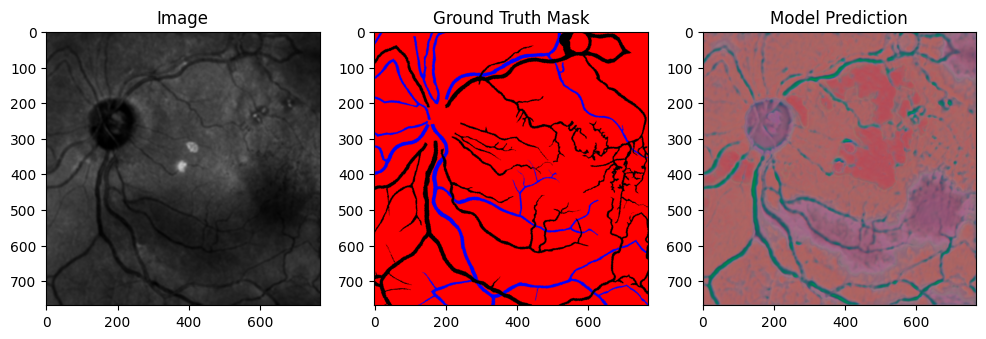

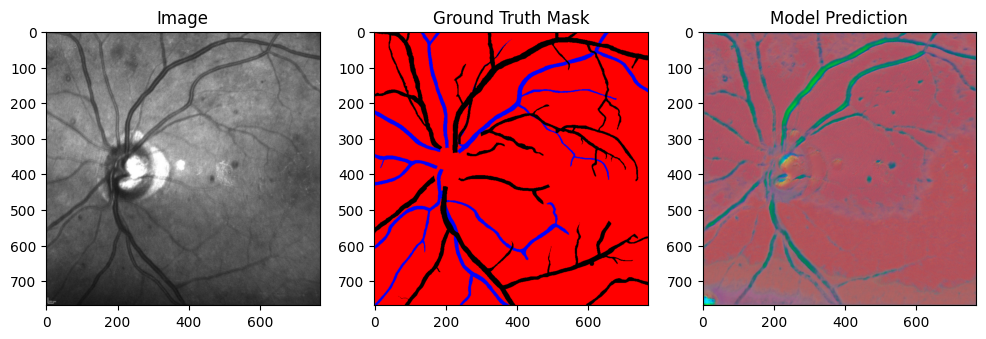

100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Validation Loss
IOU Loss: 0.22857779264450073 DICE Loss: 0.17392055690288544
Validation Loss: 0.5219757556915283


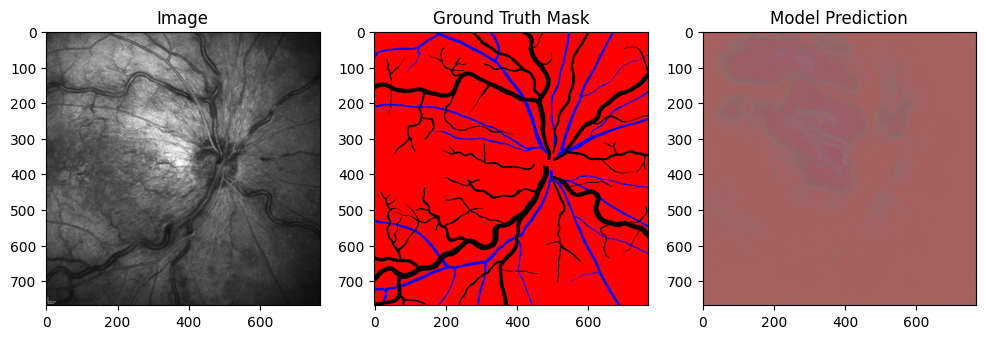

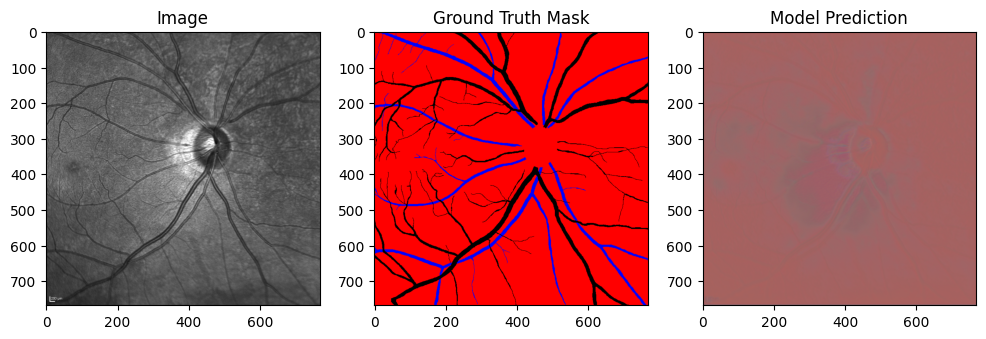

100%|██████████| 27/27 [00:39<00:00,  1.46s/it]


Train Results
IOU Loss: 0.02403024397790432,IOU: 0.23017189434035815 , DICE Loss: 0.017784595489501953, MAPE Loss: 0.013265173882246017
Epoch 2/150, Loss: 0.48268614102292945


100%|██████████| 27/27 [00:39<00:00,  1.47s/it]


Train Results
IOU Loss: 0.02362336963415146,IOU: 0.23020085022409884 , DICE Loss: 0.017342472448945045, MAPE Loss: 0.01236914936453104
Epoch 3/150, Loss: 0.46151931970207777


100%|██████████| 27/27 [00:41<00:00,  1.55s/it]


Train Results
IOU Loss: 0.023291733115911484,IOU: 0.23019826493963128 , DICE Loss: 0.01698734611272812, MAPE Loss: 0.012393909506499767
Epoch 4/150, Loss: 0.44680717145955123


100%|██████████| 27/27 [00:40<00:00,  1.51s/it]


Train Results
IOU Loss: 0.02290606126189232,IOU: 0.23020014786861998 , DICE Loss: 0.016580142080783844, MAPE Loss: 0.01211554929614067
Epoch 5/150, Loss: 0.43375533598440663


100%|██████████| 27/27 [00:40<00:00,  1.51s/it]


Train Results
IOU Loss: 0.022475097328424454,IOU: 0.2302049410959112 , DICE Loss: 0.01613232120871544, MAPE Loss: 0.011602730490267277
Epoch 6/150, Loss: 0.4202969228779828


100%|██████████| 27/27 [00:41<00:00,  1.52s/it]


Train Results
IOU Loss: 0.022054769098758698,IOU: 0.23020826615439396 , DICE Loss: 0.01570270024240017, MAPE Loss: 0.011257050558924675
Epoch 7/150, Loss: 0.40932911413687245


100%|██████████| 27/27 [00:41<00:00,  1.52s/it]


Train Results
IOU Loss: 0.02190573140978813,IOU: 0.2302123184448298 , DICE Loss: 0.015552030876278877, MAPE Loss: 0.010973852127790451
Epoch 8/150, Loss: 0.39486621927331994


100%|██████████| 27/27 [00:40<00:00,  1.51s/it]


Train Results
IOU Loss: 0.021537719294428825,IOU: 0.23021642840660206 , DICE Loss: 0.015183649957180023, MAPE Loss: 0.010579024441540241
Epoch 9/150, Loss: 0.3825858467155033


100%|██████████| 27/27 [00:44<00:00,  1.65s/it]


Train Results
IOU Loss: 0.021089527755975723,IOU: 0.2302207137440567 , DICE Loss: 0.01474191714078188, MAPE Loss: 0.010441293008625507
Epoch 10/150, Loss: 0.3713358795201337


100%|██████████| 27/27 [00:41<00:00,  1.53s/it]


Train Results
IOU Loss: 0.02059818059206009,IOU: 0.23022085445829177 , DICE Loss: 0.014266164042055607, MAPE Loss: 0.010102559812366962
Epoch 11/150, Loss: 0.3593476580248939


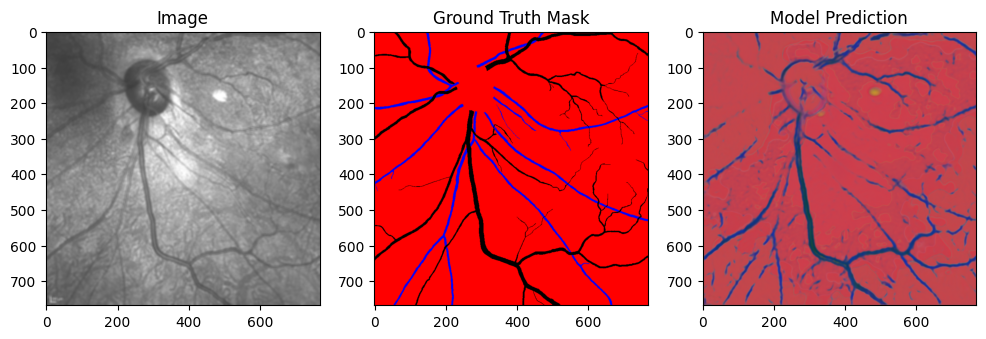

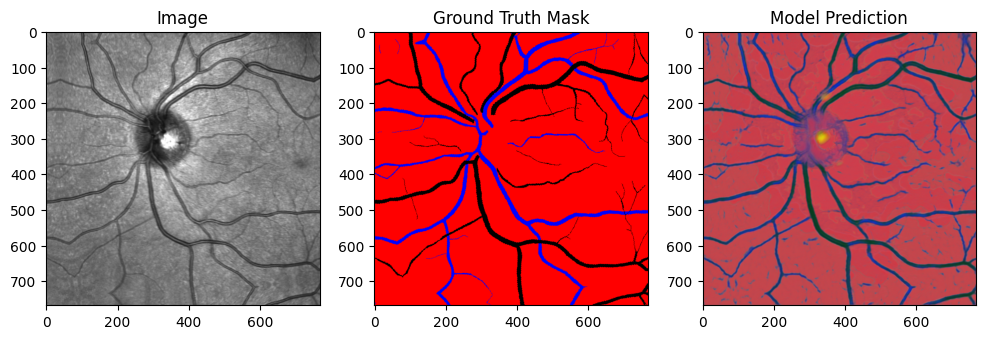

100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Validation Loss
IOU Loss: 0.18731193244457245 DICE Loss: 0.1302529275417328
Validation Loss: 0.3569035232067108


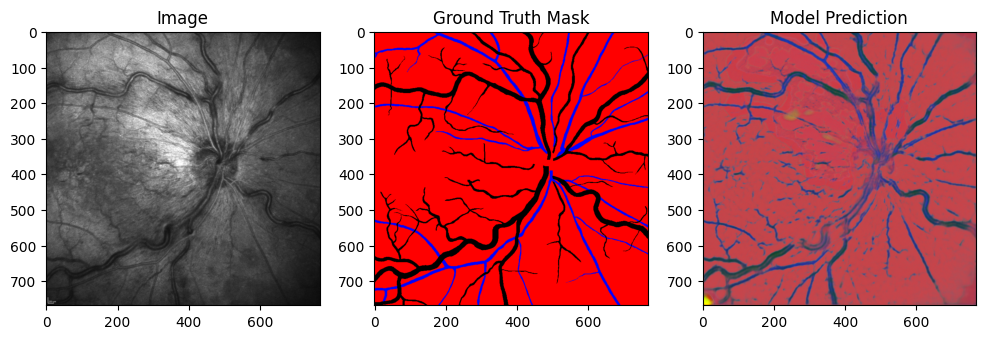

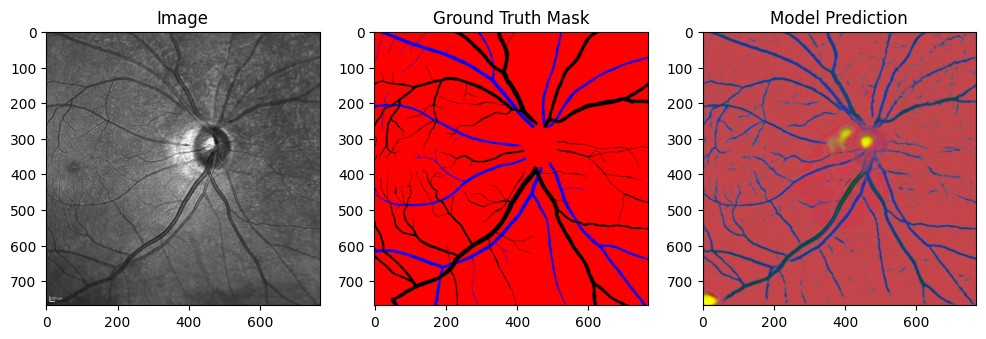

100%|██████████| 27/27 [00:41<00:00,  1.53s/it]


Train Results
IOU Loss: 0.020542427897453308,IOU: 0.23022224503016986 , DICE Loss: 0.014212732203304768, MAPE Loss: 0.009865821339190006
Epoch 12/150, Loss: 0.34925372733010185


100%|██████████| 27/27 [00:41<00:00,  1.54s/it]


Train Results
IOU Loss: 0.019956134259700775,IOU: 0.2302242693784163 , DICE Loss: 0.01365751028060913, MAPE Loss: 0.009608365595340729
Epoch 13/150, Loss: 0.3379928878060094


100%|██████████| 27/27 [00:41<00:00,  1.54s/it]


Train Results
IOU Loss: 0.020112941041588783,IOU: 0.23022904702237104 , DICE Loss: 0.013804824091494083, MAPE Loss: 0.009122014045715332
Epoch 14/150, Loss: 0.32724161059768114


100%|██████████| 27/27 [00:41<00:00,  1.55s/it]


Train Results
IOU Loss: 0.019387705251574516,IOU: 0.2302304747409527 , DICE Loss: 0.013130574487149715, MAPE Loss: 0.008901889435946941
Epoch 15/150, Loss: 0.31804736896797464


100%|██████████| 27/27 [00:41<00:00,  1.55s/it]


Train Results
IOU Loss: 0.01901164837181568,IOU: 0.23022812623982022 , DICE Loss: 0.01278794463723898, MAPE Loss: 0.008733904920518398
Epoch 16/150, Loss: 0.30875592209674696


100%|██████████| 27/27 [00:41<00:00,  1.55s/it]


Train Results
IOU Loss: 0.018502317368984222,IOU: 0.2302261818769579 , DICE Loss: 0.012331287376582623, MAPE Loss: 0.008584576658904552
Epoch 17/150, Loss: 0.29969012295758285


100%|██████████| 27/27 [00:42<00:00,  1.59s/it]


Train Results
IOU Loss: 0.018679631873965263,IOU: 0.2302249425287164 , DICE Loss: 0.012489312328398228, MAPE Loss: 0.008210877887904644
Epoch 18/150, Loss: 0.29061725956422313


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.017813701182603836,IOU: 0.2302230116325696 , DICE Loss: 0.011727026663720608, MAPE Loss: 0.008025293238461018
Epoch 19/150, Loss: 0.2819124195310805


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.017789006233215332,IOU: 0.23022471420504376 , DICE Loss: 0.011705632321536541, MAPE Loss: 0.0078194011002779
Epoch 20/150, Loss: 0.27376295902110914


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.017343470826745033,IOU: 0.23022230163556942 , DICE Loss: 0.011322831735014915, MAPE Loss: 0.007840183563530445
Epoch 21/150, Loss: 0.2664505795196251


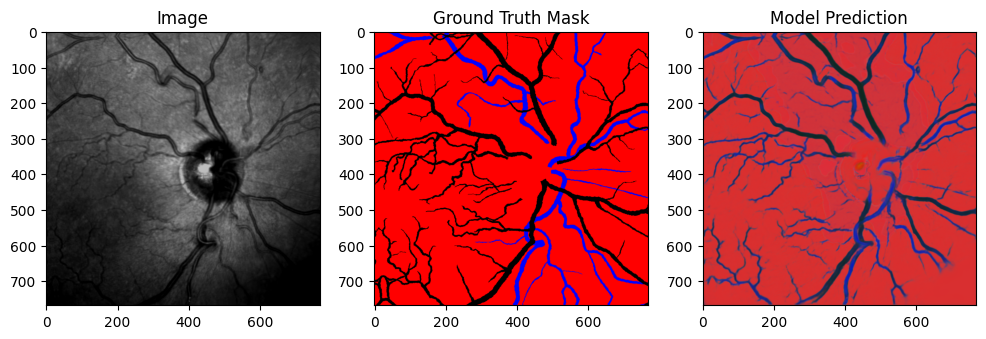

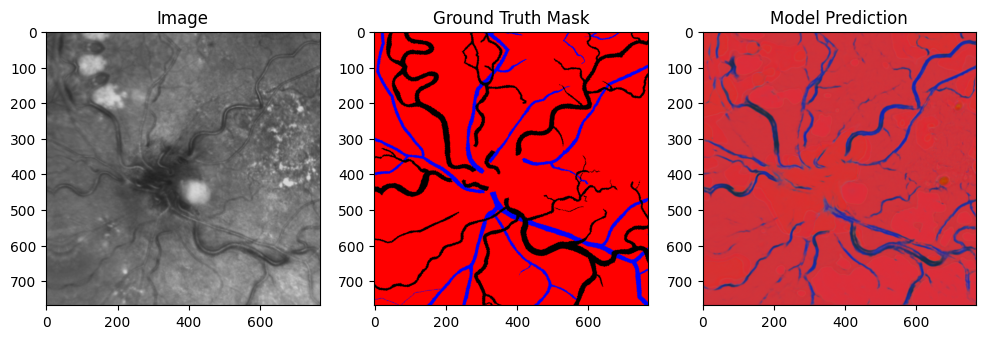

100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


Validation Loss
IOU Loss: 0.1598958820104599 DICE Loss: 0.10517311096191406
Validation Loss: 0.2683597008387248


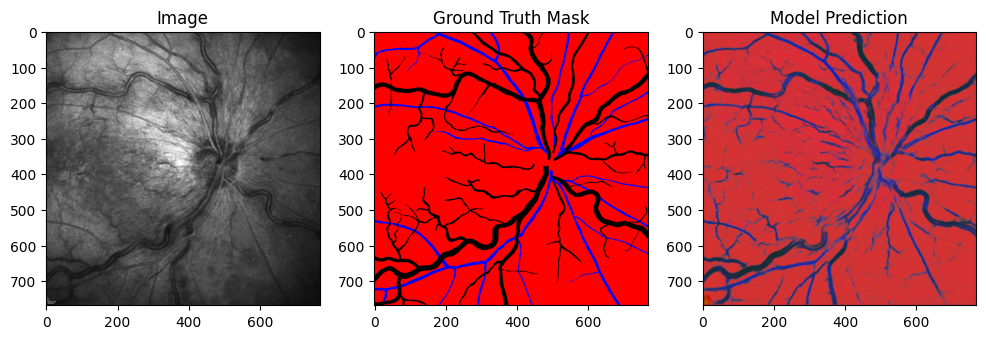

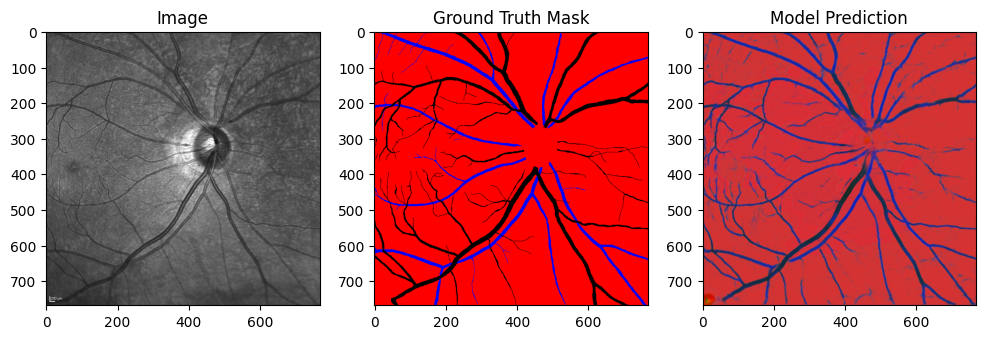

100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.017141366377472878,IOU: 0.23022472798470006 , DICE Loss: 0.011151159182190895, MAPE Loss: 0.0071732946671545506
Epoch 22/150, Loss: 0.2579082990134204


100%|██████████| 27/27 [00:42<00:00,  1.57s/it]


Train Results
IOU Loss: 0.016790878027677536,IOU: 0.23022512370427486 , DICE Loss: 0.010856317356228828, MAPE Loss: 0.007303175516426563
Epoch 23/150, Loss: 0.2503396957008927


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.016094719991087914,IOU: 0.23022489586975348 , DICE Loss: 0.010281262919306755, MAPE Loss: 0.007168608717620373
Epoch 24/150, Loss: 0.244690321109913


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.016239654272794724,IOU: 0.23022279827465028 , DICE Loss: 0.010399842634797096, MAPE Loss: 0.007036081049591303
Epoch 25/150, Loss: 0.23730760481622484


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.015474838204681873,IOU: 0.23022219612379466 , DICE Loss: 0.00978071615099907, MAPE Loss: 0.006772901862859726
Epoch 26/150, Loss: 0.22932480661957352


100%|██████████| 27/27 [00:42<00:00,  1.57s/it]


Train Results
IOU Loss: 0.015308795496821404,IOU: 0.230221915074264 , DICE Loss: 0.009648429229855537, MAPE Loss: 0.006446339190006256
Epoch 27/150, Loss: 0.22347533537281883


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.015248605981469154,IOU: 0.23022423448362653 , DICE Loss: 0.00960066169500351, MAPE Loss: 0.006488935090601444
Epoch 28/150, Loss: 0.21788286721264874


100%|██████████| 27/27 [00:42<00:00,  1.57s/it]


Train Results
IOU Loss: 0.014806346036493778,IOU: 0.23022427856701297 , DICE Loss: 0.009252647869288921, MAPE Loss: 0.006295188795775175
Epoch 29/150, Loss: 0.21158453987704384


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.015004003420472145,IOU: 0.2302242519179235 , DICE Loss: 0.00940753985196352, MAPE Loss: 0.0060936217196285725
Epoch 30/150, Loss: 0.20703042657287032


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.013940740376710892,IOU: 0.23022476860908503 , DICE Loss: 0.008586318232119083, MAPE Loss: 0.005942442920058966
Epoch 31/150, Loss: 0.20088194807370505


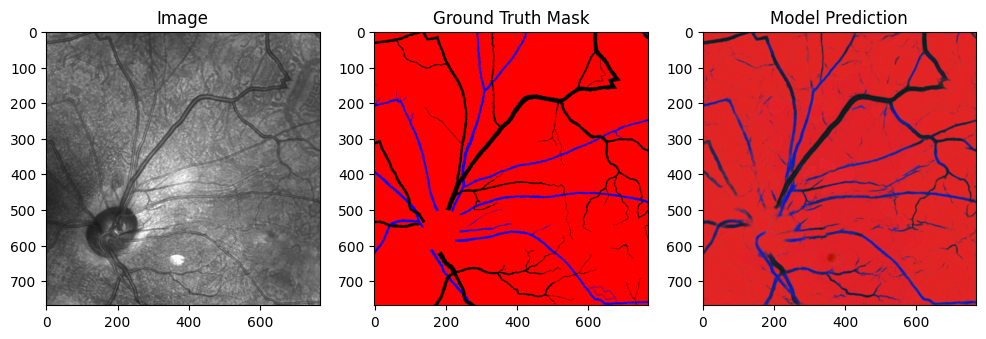

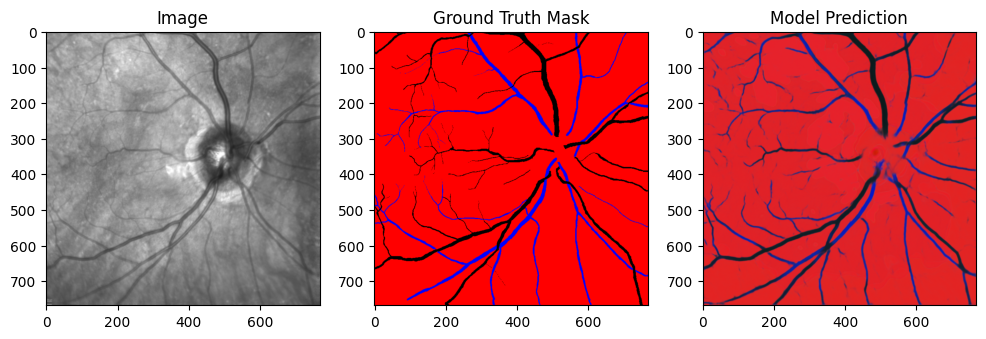

100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Validation Loss
IOU Loss: 0.1309652030467987 DICE Loss: 0.08149147033691406
Validation Loss: 0.2009138415257136


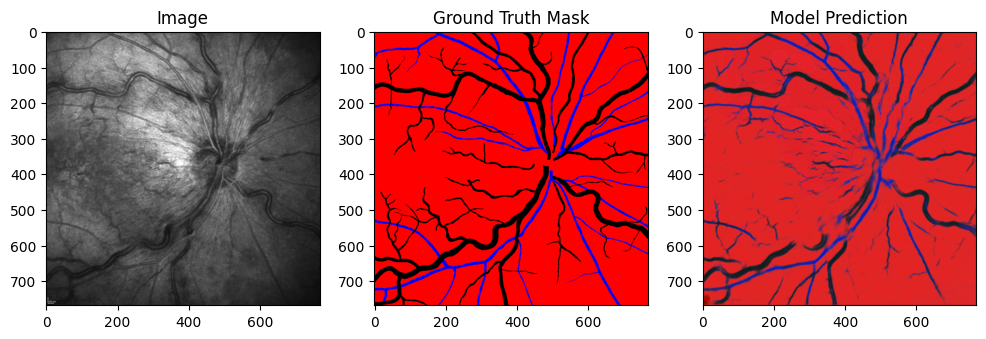

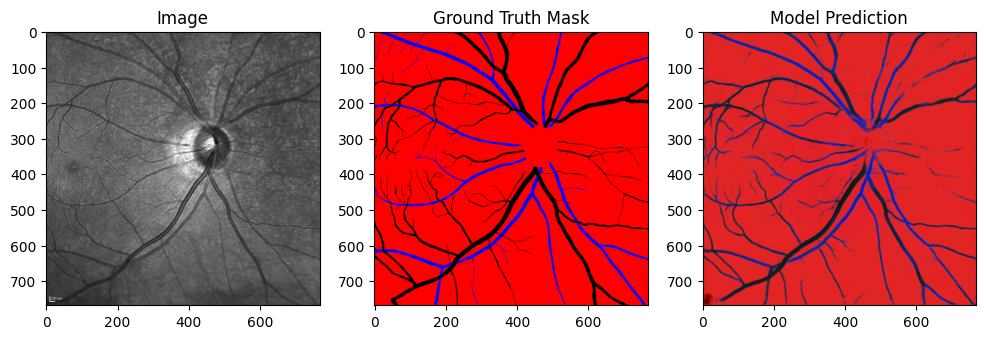

100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.013588560745120049,IOU: 0.23022208880985714 , DICE Loss: 0.008320673368871212, MAPE Loss: 0.005877768155187368
Epoch 32/150, Loss: 0.19547176857789358


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


Train Results
IOU Loss: 0.013820345513522625,IOU: 0.23022034724854046 , DICE Loss: 0.008495156653225422, MAPE Loss: 0.005662498530000448
Epoch 33/150, Loss: 0.1886135670873854


100%|██████████| 27/27 [00:42<00:00,  1.59s/it]


Train Results
IOU Loss: 0.013074559159576893,IOU: 0.2302197567402552 , DICE Loss: 0.007938475348055363, MAPE Loss: 0.00549094146117568
Epoch 34/150, Loss: 0.18589682821874265


100%|██████████| 27/27 [00:42<00:00,  1.59s/it]


Train Results
IOU Loss: 0.01321539655327797,IOU: 0.2302192180159355 , DICE Loss: 0.00804255623370409, MAPE Loss: 0.005454897414892912
Epoch 35/150, Loss: 0.18027265866597494


100%|██████████| 27/27 [00:43<00:00,  1.62s/it]


Train Results
IOU Loss: 0.012888400815427303,IOU: 0.23021863518658556 , DICE Loss: 0.007801636587828398, MAPE Loss: 0.005305586848407984
Epoch 36/150, Loss: 0.1746336078202283


100%|██████████| 27/27 [00:43<00:00,  1.62s/it]


Train Results
IOU Loss: 0.012622050009667873,IOU: 0.2302183873628161 , DICE Loss: 0.007607290055602789, MAPE Loss: 0.005193118005990982
Epoch 37/150, Loss: 0.1720004070688177


100%|██████████| 27/27 [00:43<00:00,  1.62s/it]


Train Results
IOU Loss: 0.012213272042572498,IOU: 0.23021752483230307 , DICE Loss: 0.007312282454222441, MAPE Loss: 0.005057786591351032
Epoch 38/150, Loss: 0.16758696569336784


100%|██████████| 27/27 [00:43<00:00,  1.62s/it]


Train Results
IOU Loss: 0.011725567281246185,IOU: 0.230217379103004 , DICE Loss: 0.006965369917452335, MAPE Loss: 0.00482126185670495
Epoch 39/150, Loss: 0.162258122254301


 74%|███████▍  | 20/27 [00:32<00:11,  1.59s/it]

In [ ]:
model.to(device)
trainLoss = []
valLoss = []

# Training loop
for epoch in range(epoch_num):
    model.train()
    running_loss = 0.0

    for inputs, masks in tqdm(trainDataLoader):
        inputs = inputs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()

        outputs= model(inputs)
        # print(torch.isnan(outputs).any())
        # print(torch.isinf(outputs).any())
        diceLoss = dice(outputs, masks)
        iouLoss = iou(outputs, masks)
        mapeLoss = mape(outputs, masks)
        loss = (0.85*criterion(outputs, masks))+(0.15*diceLoss)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        mIoU.update(tensor_to_numpy(outputs), tensor_to_numpy(masks))
        torch.cuda.empty_cache()
        gc.collect()

    # Print average training loss for the epoch
    print("Train Results")
    print(f'IOU Loss: {iouLoss / len(trainDataLoader)},IOU: {mIoU.calculate()} , DICE Loss: {diceLoss / len(trainDataLoader)}, MAPE Loss: {mapeLoss / len(trainDataLoader)}')
    print(f'Epoch {epoch + 1}/{epoch_num}, Loss: {running_loss / len(trainDataLoader)}')
    trainLoss.append(running_loss / len(trainDataLoader))

    if epoch % 10 == 0:
      # Visualize a few samples
      with torch.no_grad():
          sample_indices = np.random.choice(len(trainDataLoader), 1)  # Adjust the number of samples to visualize
          sample_inputs, sample_masks = next(iter(trainDataLoader))
          sample_inputs = sample_inputs.to(device)
          sample_masks = sample_masks.to(device)

          sample_outputs = model(sample_inputs)


          plot_images(sample_inputs, sample_masks, sample_outputs)

      torch.cuda.empty_cache()
      gc.collect()

      model.eval()
      with torch.no_grad():
          validation_loss = 0.0
          for inputs, masks in tqdm(testDataLoader):
              inputs = inputs.to(device)
              masks = masks.to(device)
      #         print(masks.shape)

              outputs = model(inputs)
      #         print(outputs.shape)
              diceLoss = dice(outputs, masks)
              iouLoss = iou(outputs, masks)
              loss = (0.85*criterion(outputs, masks))+(0.15*diceLoss)

              validation_loss += loss.item()

          # Print average validation loss
          print("Validation Loss")
          print(f'IOU Loss: {iouLoss / len(testDataLoader)} DICE Loss: {diceLoss / len(testDataLoader)}')
          print(f'Validation Loss: {validation_loss / len(testDataLoader)}')


          sample_indices = np.random.choice(len(testDataLoader), 1)  # Adjust the number of samples to visualize
          sample_inputs, sample_masks = next(iter(testDataLoader))
          sample_inputs = sample_inputs.to(device)
          sample_masks = sample_masks.to(device)

          sample_outputs = model(sample_inputs)


          plot_images(sample_inputs, sample_masks, sample_outputs)
          valLoss.append(validation_loss / len(testDataLoader))
# Save the trained model if needed
torch.save(model.state_dict(), 'segmentation_model_light02.pth')


In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
def calculate_miou(model, val_loader, device, n_classes=3):
    model.eval()
    class_iou = torch.zeros(n_classes,  device=device)  # To store IoU for each class
    class_counts = torch.zeros(n_classes,  device=device)  # To count the number of instances for each class

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Calculating mIoU", leave=False):
            images = images.to(device)
            masks = masks.to(device).squeeze(1)  # Squeeze the masks
            outputs = model(images)
            outputs = torch.argmax(outputs, dim=1)  # Convert to predicted class indices

            # Calculate IoU for each class
            for class_idx in range(n_classes):
                true_class = masks == class_idx
                pred_class = outputs == class_idx
                intersection = torch.logical_and(true_class, pred_class).sum(dim=[1, 2])
                union = torch.logical_or(true_class, pred_class).sum(dim=[1, 2])
                iou = intersection / (union + 1e-6)  # Add a small value to avoid division by zero
                valid = union > 0  # Only consider this class if it's present in ground truth or prediction

                class_iou[class_idx] += iou[valid].sum()
                class_counts[class_idx] += valid.sum()

    # Calculate mean IoU
    mIoU = (class_iou / (class_counts + 1e-6)).mean()  # Average over all classes
    return mIoU.item()

In [ ]:
def calculate_miou(model, val_loader, device, n_classes=3):
    model.eval()
    class_iou = torch.zeros(n_classes, device=device)  # To store IoU for each class
    class_counts = torch.zeros(n_classes, device=device)  # To count the number of instances for each class

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Calculating mIoU", leave=False):
            images = images.to(device)
            masks = masks.to(device)  # Assuming masks have three channels
            outputs = model(images)
            outputs = torch.argmax(outputs, dim=1)  # Convert to predicted class indices

            # Calculate IoU for each class
            for class_idx in range(n_classes):
                true_class = masks[:, class_idx, :, :]
                pred_class = outputs == class_idx
                intersection = torch.logical_and(true_class, pred_class).sum(dim=[1, 2])
                union = torch.logical_or(true_class, pred_class).sum(dim=[1, 2])
                iou = intersection / (union + 1e-6)  # Add a small value to avoid division by zero
                valid = union > 0  # Only consider this class if it's present in ground truth or prediction

                class_iou[class_idx] += iou[valid].sum()
                class_counts[class_idx] += valid.sum()

    # Calculate mean IoU
    class_iou[class_counts == 0] = 1.0  # Set IoU to 1.0 for classes with no instances in both GT and prediction
    mIoU = (class_iou / (class_counts + 1e-6)).mean()  # Average over all classes
    return mIoU.item()


In [ ]:
miou = calculate_miou(model, testDataLoader, device)
miou

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1,len(trainLoss)+1),trainLoss, label='Training Loss')
plt.plot(np.arange(1,len(valLoss)+1),valLoss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()
